# Find the right algorithm to detect fraudulent purchases on a website

In [1]:
#!pip install pycountry_convert

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import pycountry_convert as pc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
                              
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             recall_score, roc_auc_score, roc_curve)

## Link the two dataset by associating the IP address with its country.

In [0]:
# # load dataset
# dataset = pd.read_csv("Fraud_Data.csv")
# countries = pd.read_csv("IpAddress_to_Country.csv")
# # match country with ip address
# def transform_ip(arg) :
#     try :
#         return countries.country[(countries.lower_bound_ip_address < arg) & (countries.upper_bound_ip_address > arg)].iloc[0]
#     except IndexError :
#         return "Pays inconnu"  
# dataset["Pays"] = dataset.ip_address.apply(transform_ip)


The previous function has a long computation time so we export our new dataset in order not to repeat the operation.

In [0]:
#dataset.to_csv('/<Path>/Fraud_with_countries.csv', index = False)

In [60]:
df = pd.read_csv('Fraud_with_countries.csv')

In [240]:
#take a look at the dataset
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


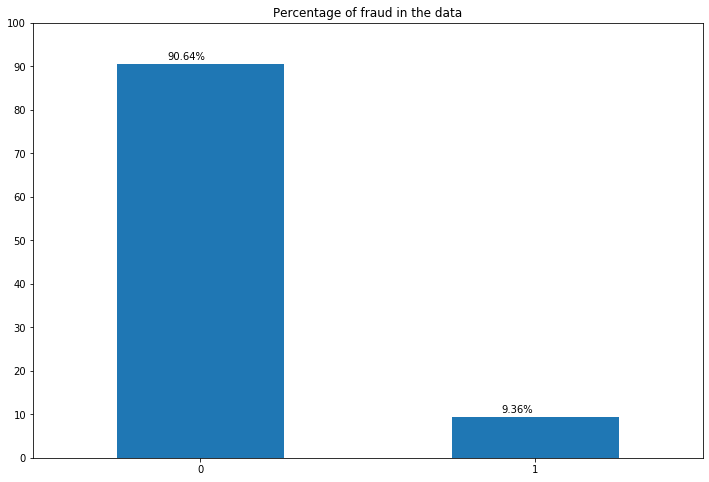

In [0]:
# Let's take a look at our target
plt.figure(figsize=(12,8))
plt.title('Percentage of fraud in the data')

ax = (df['class'].value_counts()/len(df)*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [0]:
#Let's look at the linear influence of the variables (that can be dummyfied) on our target
y=df['class']
X = df[[ 'purchase_value', 'browser', 'sex', 'age', 'country' ]]
X = pd.get_dummies(X)
X_columns = X.columns

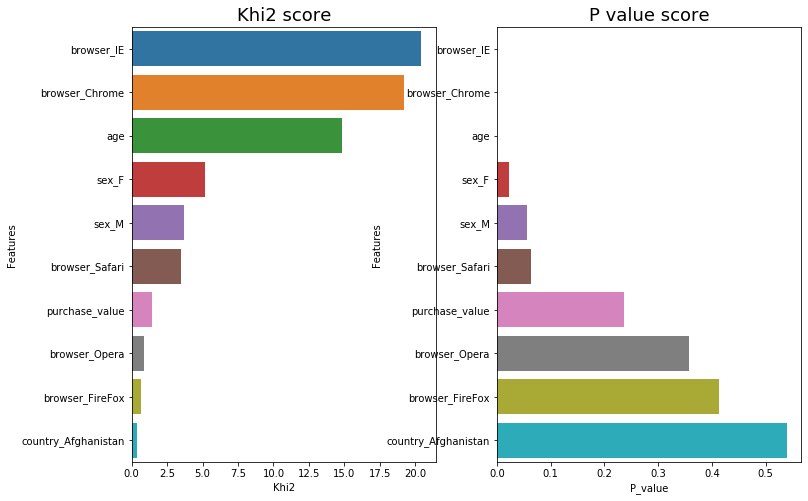

In [0]:
from sklearn.feature_selection import chi2
khi2 = chi2(X,y)
#créate a Dataframe
feature_ranking = pd.DataFrame({"Features": X_columns,
                                   "Khi2": khi2[0],
                                  "P_value" : khi2[1]})
#Sort the dataset
feature_ranking.sort_values(by = "Khi2", ascending=False)

#Graph Khi-2 score and P-Value
fig, axarr = plt.subplots(1,2, figsize=(12, 8))
z = feature_ranking.iloc[:10]
sns.barplot(x="Khi2",y="Features", 
            data = z.sort_values("Khi2", ascending=False),
            ax=axarr[0] )
sns.barplot(x="P_value",y="Features", 
            data = z.sort_values("P_value", ascending=True),
            ax=axarr[1])
axarr[0].set_title("Khi2 score", fontsize=18)
axarr[1].set_title("P value score", fontsize=18)
plt.close(2)
plt.show()

## Try a first logistic regression with these features

In [0]:
y=df['class']
X = df[[ 'purchase_value', 'browser', 'sex',  'age', 'country']]

In [0]:
# Get dummies and standardScaler separatly
from sklearn.preprocessing import StandardScaler 
sc_x = StandardScaler()
num_col = X.select_dtypes([np.number]).columns
cat_col = X.select_dtypes("object").columns
X_num = X[num_col]
X_cat =  pd.get_dummies(X[cat_col],drop_first=True)
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_num, X_cat, y, test_size =0.2, stratify = y)
X_train_num_norm = pd.DataFrame(sc_x.fit_transform(X_train_num),columns=X_train_num.columns, index = X_train_num.index)
X_test_num_norm = pd.DataFrame(sc_x.transform(X_test_num),columns=X_test_num.columns, index = X_test_num.index)

X_train = pd.merge(X_train_num_norm, X_train_cat,left_index=True, right_index=True)
X_test = pd.merge(X_test_num_norm, X_test_cat,left_index=True, right_index=True)

In [482]:
classifier = LogisticRegression() 
classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

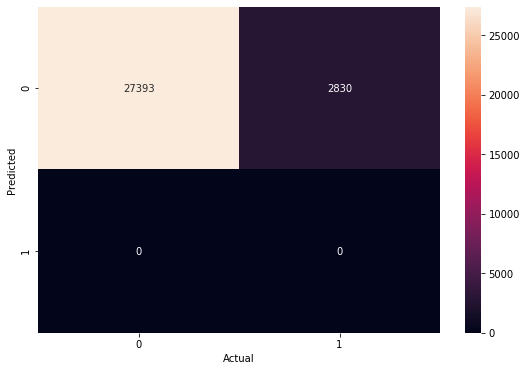

[[27393  2830]
 [    0     0]]
--*--
Classification par Regression logistique 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27393
           1       0.00      0.00      0.00      2830

    accuracy                           0.91     30223
   macro avg       0.45      0.50      0.48     30223
weighted avg       0.82      0.91      0.86     30223

False negative rate 0.0 %
False positive rate 9.36 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [483]:
y_pred_log = classifier.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_log, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par Regression logistique ")
print(classification_report(y_true = y_test, y_pred  = classifier.predict(X_test)))
print("False negative rate {} %".format(round(cm[1,0]/(cm[0,0]+cm[1,1]+cm[1,0]+cm[0,1])*100,2)))
print("False positive rate {} %".format(round(cm[0,1]/(cm[0,0]+cm[1,1]+cm[1,0]+cm[0,1])*100,2)))

We've failed to detect a single case of fraud   
Let's try a random forest

In [0]:
y=df['class']
X = df[[ 'purchase_value', 'browser', 'sex',  'age', 'country']]

In [0]:
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state = 42)
X_columns=X_train.columns

In [0]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

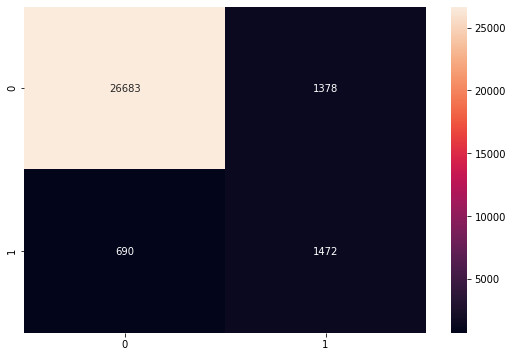

[[26683  1378]
 [  690  1472]]
--*--
Classification par random forest 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27373
           1       0.68      0.52      0.59      2850

    accuracy                           0.93     30223
   macro avg       0.82      0.75      0.78     30223
weighted avg       0.93      0.93      0.93     30223

False negative rate 2.28 %
False positive rate 4.56 %


In [0]:
y_pred_rfc = rfc.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_rfc, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par random forest ")
print(classification_report(y_true = y_test, y_pred  = rfc.predict(X_test)))
print("False negative rate {} %".format(round(cm[1,0]/(cm[0,0]+cm[1,1]+cm[1,0]+cm[0,1])*100,2)))
print("False positive rate {} %".format(round(cm[0,1]/(cm[0,0]+cm[1,1]+cm[1,0]+cm[0,1])*100,2)))

Random forest performs better, however, we only managed to detect 52% of the fraudulent operations.  

## We need feature engineering

### Time

In [8]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,week_of_purchased,signup_MONTH,signup_DAY,purchase_MONTH,purchase_DAY,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,3,February,Tuesday,April,Saturday,52 days 03:51:22,52,3,51,22
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,June,Sunday,June,Monday,0 days 04:59:04,0,4,59,4
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,January,Thursday,January,Thursday,0 days 00:00:01,0,0,0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,1,April,Tuesday,May,Monday,5 days 16:41:25,5,16,41,25
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,2,July,Tuesday,September,Wednesday,50 days 11:31:01,50,11,31,1


In [61]:
#convert to datetime
df['signup_time']=pd.to_datetime(df['signup_time'])
df['purchase_time']=pd.to_datetime(df['purchase_time'])

In [62]:
# add new columns
df['signup_date'] = df['signup_time'].apply(lambda x : x.strftime('%d/%m/%Y'))
df['signup_hour'] = df['signup_time'].apply(lambda x : x.strftime('%H:%M:%S'))

df['purchase_date'] = df['purchase_time'].apply(lambda x : x.strftime('%d/%m/%Y'))
df['purchase_hour'] = df['purchase_time'].apply(lambda x : x.strftime('%H:%M:%S'))

df["day_of_purchased"] = df["purchase_time"].map(lambda d: d.day)
df["week_of_purchased"] = [int((jour-1)*4/31)+1 for jour in df["day_of_purchased"]]

In [63]:
df['signup_MONTH'] = df['signup_time'].apply(lambda x : x.strftime('%B'))
df['signup_DAY'] = df['signup_time'].apply(lambda x : x.strftime('%A'))

df['purchase_MONTH'] = df['purchase_time'].apply(lambda x : x.strftime('%B'))
df['purchase_DAY'] = df['purchase_time'].apply(lambda x : x.strftime('%A'))

In [64]:
#add columns 
df['time_to_purchase'] = (df['purchase_time'] - df['signup_time'])
df['day_to_purchase'] = df['time_to_purchase'].apply(lambda x : x.days)

In [65]:
#function to extract h/m/s from timedelta format ('52 days 03:51:22') and create new features
def extract_hours(x):
    days = x.days
    hours, remainder = divmod(x.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours
def extract_minutes(x):
    days = x.days
    hours, remainder = divmod(x.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return minutes
def extract_seconds(x):
    days = x.days
    #hours, remainder = divmod(a.seconds, 3600)
    hours, remainder = divmod(x.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return seconds

df['hours_to_purchase'] = df['time_to_purchase'].apply(lambda x : extract_hours(x))
df['minutes_to_purchase'] = df['time_to_purchase'].apply(lambda x : extract_minutes(x))
df['second_to_purchase'] = df['time_to_purchase'].apply(lambda x : extract_seconds(x))

Some purchases are made in less than a second, probably by robots.

In [66]:
df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,week_of_purchased,signup_MONTH,signup_DAY,purchase_MONTH,purchase_DAY,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,3,February,Tuesday,April,Saturday,52 days 03:51:22,52,3,51,22
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,June,Sunday,June,Monday,0 days 04:59:04,0,4,59,4
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,January,Thursday,January,Thursday,0 days 00:00:01,0,0,0,1


In [67]:
df.head()['time_to_purchase']

0   52 days 03:51:22
1    0 days 04:59:04
2    0 days 00:00:01
3    5 days 16:41:25
4   50 days 11:31:01
Name: time_to_purchase, dtype: timedelta64[ns]

In [68]:
#add column if it's to speed for purchase
df['to_speed_for_purchase'] = df.apply(lambda row: 1 if row['hours_to_purchase']==0 and
                                       row['minutes_to_purchase']<1 and
                                       row['day_to_purchase']<1 and
                                       row['second_to_purchase']<2
                                    else 0, axis=1)

In [69]:
fraudulent = (df[df['to_speed_for_purchase'] == 1]['class'].value_counts()/len(df[df['to_speed_for_purchase'] == 1]))*100
print("The percentage of fraud of what we identified as robots is equal to {}%".format(int(fraudulent[1])))

The percentage of fraud of what we identified as robots is equal to 100%


There was a spike in fraudulent purchases in January

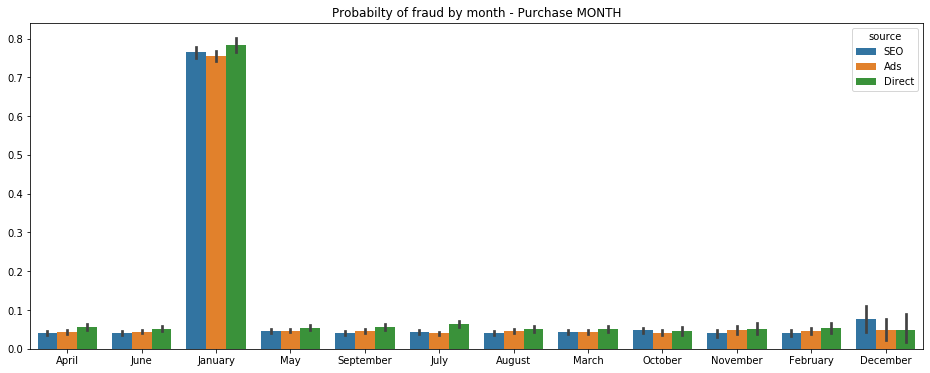

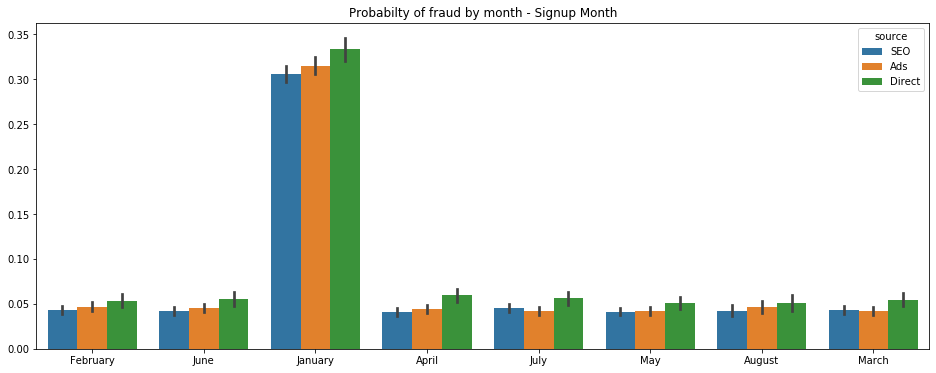

In [70]:
plt.figure(figsize = (16,6))
sns.barplot(x="purchase_MONTH", y="class", hue = 'source',  data=df);
plt.title('Probabilty of fraud by month - Purchase MONTH')
plt.xlabel('');
plt.ylabel('');
plt.show()
## not the same with signup MONTH
plt.figure(figsize = (16,6))
sns.barplot(x="signup_MONTH", y="class", hue = 'source',  data=df);
plt.title('Probabilty of fraud by month - Signup Month')
plt.xlabel('');
plt.ylabel('');

In [71]:
# Identify if the purchase took place in January
df['January'] = df['purchase_MONTH'].apply(lambda x : 1 if x == 'January' else 0)

### Device

In [74]:
# add a columns that count device apparition
device_nb = pd.DataFrame({'count' :df.device_id.value_counts()})
device_nb['device_id'] = device_nb.index
df = df.merge(device_nb, on='device_id', how='left')
df.rename(columns={'count':'Device_apparition'}, inplace = True)

In [75]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,purchase_MONTH,purchase_DAY,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,January,Device_apparition
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,April,Saturday,52 days 03:51:22,52,3,51,22,0,0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,June,Monday,0 days 04:59:04,0,4,59,4,0,0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,January,Thursday,0 days 00:00:01,0,0,0,1,1,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,May,Monday,5 days 16:41:25,5,16,41,25,0,0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,September,Wednesday,50 days 11:31:01,50,11,31,1,0,0,1


In [76]:
device_nb

,count,device_id
CQTUVBYIWWWBC,20,CQTUVBYIWWWBC
NGQCKIADMZORL,20,NGQCKIADMZORL
ITUMJCKWEYNDD,20,ITUMJCKWEYNDD
EQYVNEGOFLAWK,20,EQYVNEGOFLAWK
KIPFSCNUGOLDP,20,KIPFSCNUGOLDP
...,...,...
QCTWHJRGWLDZQ,1,QCTWHJRGWLDZQ
AGSKUOJNJQGYC,1,AGSKUOJNJQGYC
UWJAELNETODCP,1,UWJAELNETODCP
EAZCUGIUQQEAO,1,EAZCUGIUQQEAO


In [77]:
# Take a look at one device, we can see this is a fraudulous one
## maybe there's even a case of fraud that went undetected?
df[df['device_id'] == 'ZUSVMDEZRBDTX'][['purchase_MONTH', 'time_to_purchase', 'class']]

,purchase_MONTH,time_to_purchase,class
9679,January,0 days 00:00:01,1
22782,January,0 days 00:00:01,1
27520,January,0 days 00:00:01,1
33712,January,0 days 00:00:01,1
43697,January,0 days 00:00:01,1
51626,January,0 days 00:00:01,1
55085,January,0 days 00:00:01,1
57766,January,0 days 00:00:01,1
59817,January,0 days 00:00:01,1
61092,January,0 days 00:00:01,1


In [78]:
#let's take a look at the most common device and print the percentage of fraud
print(df[df['device_id'] == 'ZUSVMDEZRBDTX']['class'].value_counts())
perc = df[df['device_id'] == 'ZUSVMDEZRBDTX']['class'].value_counts()[1]/len(df[df['device_id'] == 'ZUSVMDEZRBDTX'])
perc

1    19
0     1
Name: class, dtype: int64


0.95

In [79]:
#Let's tak a look at a second one and print the percentage of fraud
print(df[df['device_id'] == 'ITUMJCKWEYNDD']['class'].value_counts())
perc_ = df[df['device_id'] == 'ITUMJCKWEYNDD']['class'].value_counts()[1]/len(df[df['device_id'] == 'ITUMJCKWEYNDD'])
perc_

1    19
0     1
Name: class, dtype: int64


0.95

In [80]:
device_perc = pd.DataFrame({'device_perc' :df.groupby('device_id').mean()['class']})
device_perc = device_perc.reset_index()
df = df.merge(device_perc, on='device_id', how='left')

In [81]:
# do the same with ip_adress
ip_nb =  pd.DataFrame({'count' :df.ip_address.value_counts()})
ip_nb['ip_address'] = ip_nb.index
df = df.merge(ip_nb, on='ip_address', how='left')

In [82]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,January,Device_apparition,device_perc,count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,52 days 03:51:22,52,3,51,22,0,0,1,0.000000,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,0 days 04:59:04,0,4,59,4,0,0,1,0.000000,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,0 days 00:00:01,0,0,0,1,1,1,12,0.916667,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,5 days 16:41:25,5,16,41,25,0,0,1,0.000000,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,50 days 11:31:01,50,11,31,1,0,0,1,0.000000,1


In [85]:
# Rename the two news columns that count device and ip apparition
df.rename(columns={'count':'Ip_apparition'}, inplace=True)

In [86]:
df.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,January,Device_apparition,device_perc,Ip_apparition
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,52 days 03:51:22,52,3,51,22,0,0,1,0.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,0 days 04:59:04,0,4,59,4,0,0,1,0.0,1


### Countries

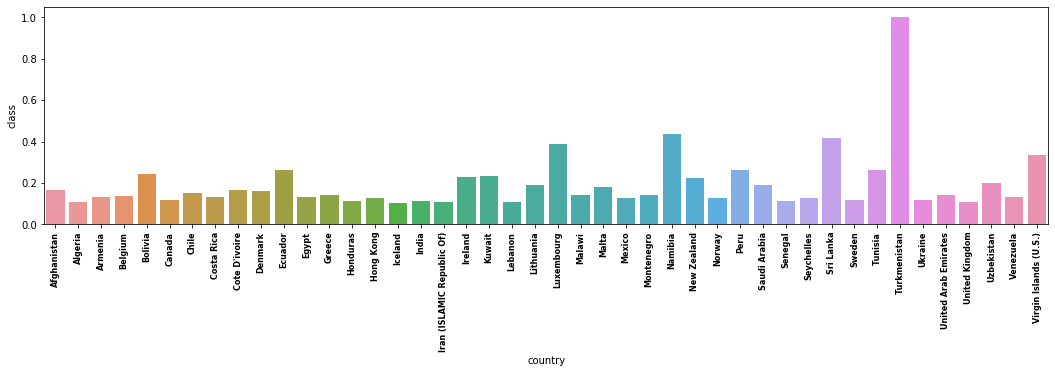

In [87]:
# percentage of fraud group by pays
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_fraud = df[["country", "class"]].groupby(['country'],as_index=False).mean()
sns.barplot(x='country', y='class', data=average_fraud[average_fraud['class']>0.1]);
plt.xticks(rotation=90, size = 8, weight = 'bold');

Let's take a look at the most "dangerous" countries and their number of purchases.

In [88]:
a = pd.DataFrame(df.groupby('country').mean()['class']).sort_values(by = 'class', ascending = False)
a['nb_of_connexion'] = df.country.value_counts()
a[:8]

,class,nb_of_connexion
country,,
Turkmenistan,1.000000,1
Namibia,0.434783,23
Sri Lanka,0.419355,31
Luxembourg,0.388889,72
Virgin Islands (U.S.),0.333333,3
Ecuador,0.264151,106
Tunisia,0.262712,118
Peru,0.260504,119


This time, let's look at the countries with the most purchases and their fraud rates.

In [89]:
b=a.sort_values(by = 'nb_of_connexion', ascending = False)
b[:8]

,class,nb_of_connexion
country,,
United States,0.095626,58049
China,0.086642,12038
Japan,0.097865,7306
United Kingdom,0.106236,4490
Korea Republic of,0.091302,4162
Germany,0.071860,3646
France,0.094907,3161
Canada,0.116975,2975


In [90]:
#count contry apparition
country_nb = pd.DataFrame({'count' :df.country.value_counts()})
country_nb['country'] = country_nb.index
df = df.merge(country_nb, on='country', how='left')
df.rename(columns={'count':'country_apparition' }, inplace=True)
df['country_apparition'] = df['country_apparition'].apply(lambda x : 0 if np.isnan(x) else x)

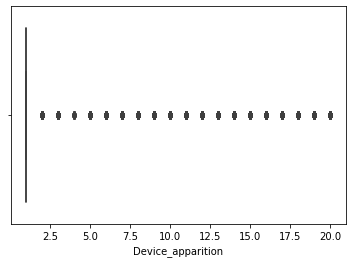

In [91]:
sns.boxplot(df['Device_apparition']);

In [92]:
df['outlier_device_apparition'] = df.Device_apparition.apply(lambda x : 1 if x >4  else 0 )

In [93]:
# Add column continent so we 
df['country'] = df['country'].fillna('Missing')
def find_continent(arg):
    
    try :
        country_code = pc.country_name_to_country_alpha2(arg, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        return continent_name
    except KeyError :
        return 'Missing'
df['continent'] = df['country'].apply(find_continent)

df['continent'] = df.continent.replace({
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
})

## Retry Models

In [94]:
df.head(1)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,January,Device_apparition,device_perc,Ip_apparition,country_apparition,outlier_device_apparition,continent
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,51,22,0,0,1,0.0,1,7306.0,0,Asia


### Let's launch a decision tree in order to visualize it

In [130]:
y=df['class']
X = df[['Device_apparition', 'Ip_apparition', 'day_to_purchase', 'minutes_to_purchase', 'second_to_purchase', 
        'to_speed_for_purchase','outlier_device_apparition', 'hours_to_purchase','day_of_purchased',
        'January','country_apparition', 'continent', 'browser', 'device_perc']]
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state = 42)
X_columns=X_train.columns

In [131]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier( max_depth = 5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [132]:
print("Decision tree classifier".center(50, "-"))
print("Tree score on train :",tree.score(X_train, y_train))  ### donne l'accuracy
print("Tree score on test", tree.score(X_test, y_test))

-------------Decision tree classifier-------------
Tree score on train : 0.9873933939398952
Tree score on test 0.9877245806174105


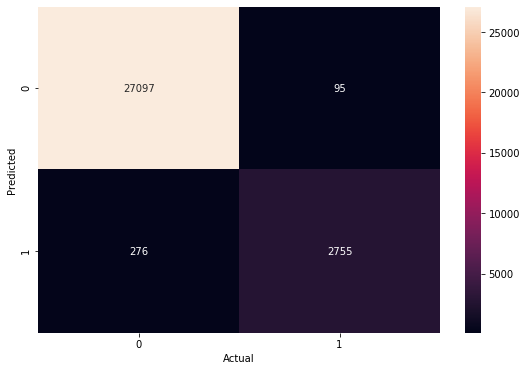

[[27097    95]
 [  276  2755]]
--*--
Classification par Decision Tree
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     27373
           1       0.91      0.97      0.94      2850

    accuracy                           0.99     30223
   macro avg       0.95      0.98      0.97     30223
weighted avg       0.99      0.99      0.99     30223



In [134]:
y_pred_tree = tree.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_tree, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par Decision Tree")
print(classification_report(y_true = y_test, y_pred  = tree.predict(X_test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


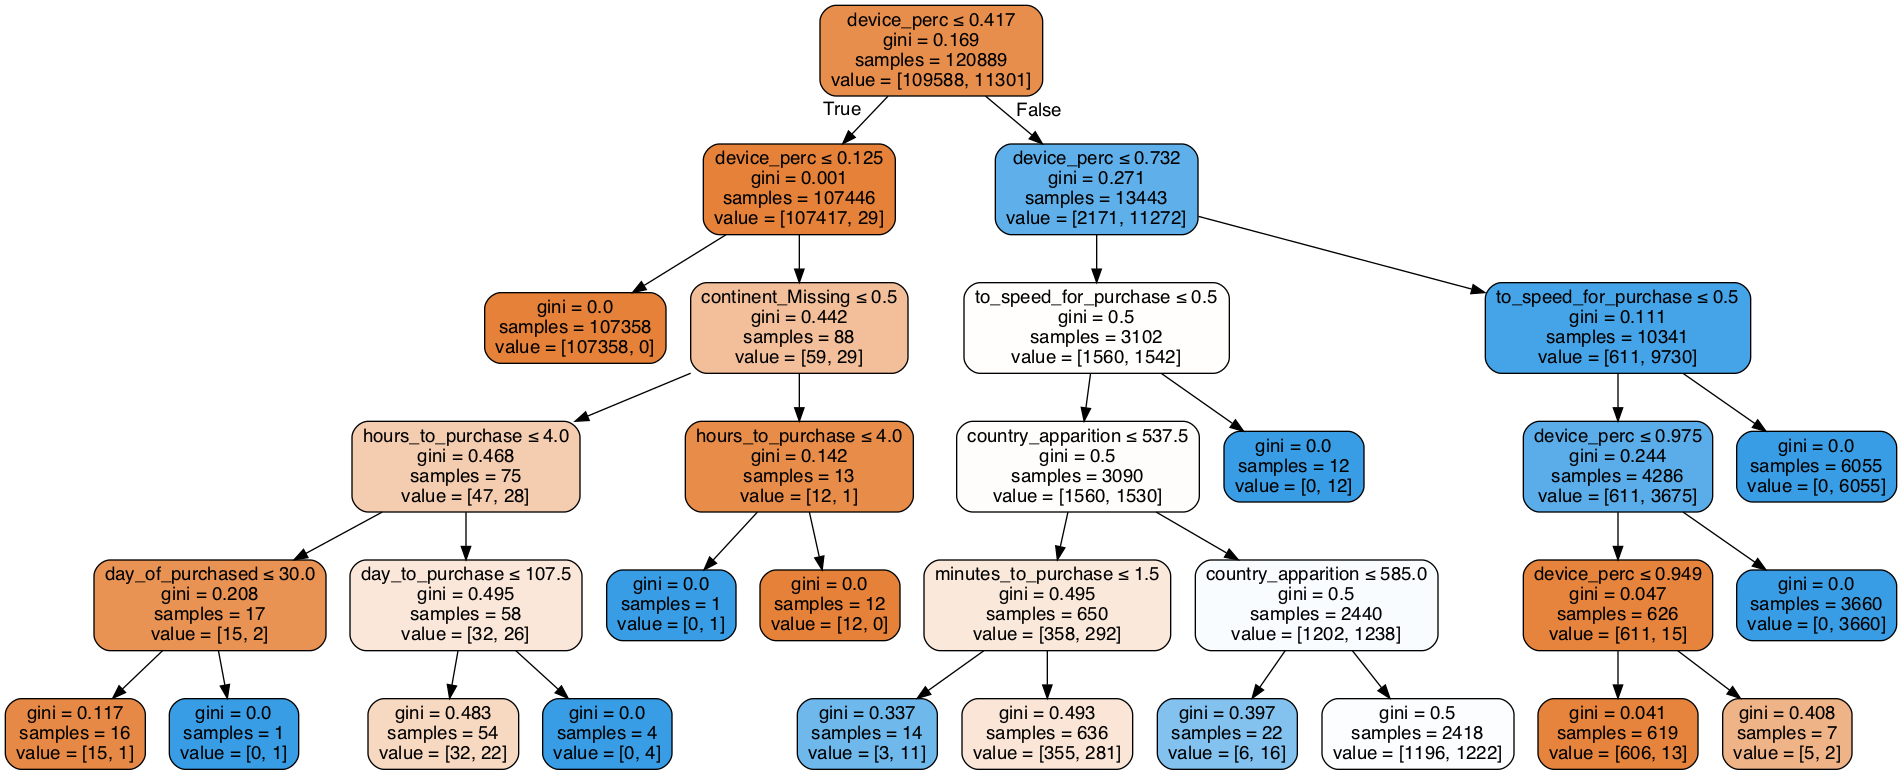

In [107]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Try a balanced and non balanced logistic regression

In [143]:
y=df['class']
X = df[['Device_apparition', 'Ip_apparition', 'day_to_purchase', 'minutes_to_purchase', 'second_to_purchase', 
        'to_speed_for_purchase','outlier_device_apparition', 'hours_to_purchase','day_of_purchased',
        'January','country_apparition', 'continent', 'browser', 'device_perc']]

In [144]:
# Get dummies and standardScaler
from sklearn.preprocessing import StandardScaler 
sc_x = StandardScaler()
num_col = X.select_dtypes([np.number]).columns
cat_col = X.select_dtypes("object").columns
X_num = X[num_col]
X_cat =  pd.get_dummies(X[cat_col],drop_first=True)
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_num, X_cat, y, test_size =0.2)
X_train_num_norm = pd.DataFrame(sc_x.fit_transform(X_train_num),columns=X_train_num.columns, index = X_train_num.index)
X_test_num_norm = pd.DataFrame(sc_x.transform(X_test_num),columns=X_test_num.columns, index = X_test_num.index)

X_train = pd.merge(X_train_num_norm, X_train_cat,left_index=True, right_index=True)
X_test = pd.merge(X_test_num_norm, X_test_cat,left_index=True, right_index=True)

In [145]:

classifier = LogisticRegression()
classifier_blced = LogisticRegression(class_weight='balanced')
classifier.fit(X_train, y_train)
classifier_blced.fit(X_train, y_train)

print("Logistic classifier".center(50, "-"))
print("Logistic score on train :",classifier.score(X_train, y_train))  ### donne l'accuracy
print("Logistic score on test", classifier.score(X_test, y_test))

---------------Logistic classifier----------------
Logistic score on train : 0.9874761144521007
Logistic score on test 0.9869966581742382


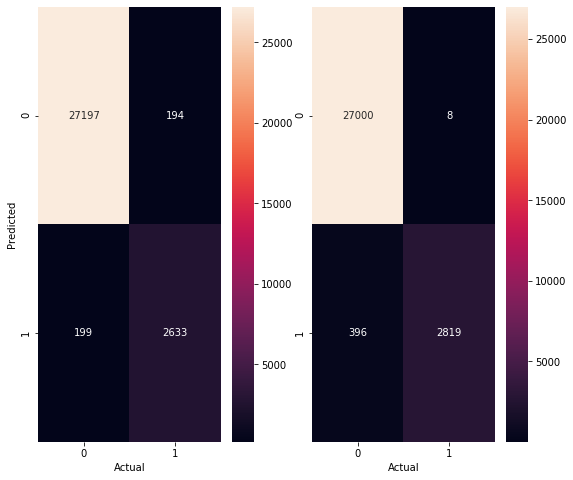

--*--
Classification by Regression logistique

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27396
           1       0.93      0.93      0.93      2827

    accuracy                           0.99     30223
   macro avg       0.96      0.96      0.96     30223
weighted avg       0.99      0.99      0.99     30223

--*--
Classification by Regression logistique with resampling

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     27396
           1       0.88      1.00      0.93      2827

    accuracy                           0.99     30223
   macro avg       0.94      0.99      0.96     30223
weighted avg       0.99      0.99      0.99     30223



In [146]:
from sklearn.metrics import confusion_matrix
y_pred_log_best = classifier.predict(X_test)
y_pred_blcd = classifier_blced.predict(X_test)

f, ax = plt.subplots(1,2,figsize=(9, 8))

cm = confusion_matrix(y_pred_log_best, y_test)
cm_blcd = confusion_matrix(y_pred_blcd, y_test)

sns.heatmap(cm, annot=True, fmt = 'd', ax = ax[0])
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
sns.heatmap(cm_blcd, annot=True, fmt = 'd', ax = ax[1])
ax[1].set_xlabel("Actual")
plt.show()
print('*'.center(5,'-'))
print("Classification by Regression logistique\n")
print(classification_report(y_true = y_test, y_pred  = classifier.predict(X_test)))
print('*'.center(5,'-'))
print("Classification by Regression logistique with resampling\n")
print(classification_report(y_true = y_test, y_pred  = classifier_blced.predict(X_test)))

We have a much higher score than our first model  
If we take into account the weight of class in our logistic regression model we are able to predict almost all cases of fraud.   However, we have more cases of false positives

### Random Forest

In [147]:
rfc = RandomForestClassifier(n_estimators = 300)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

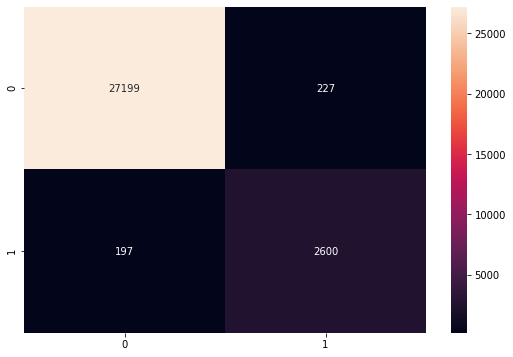

[[27199   227]
 [  197  2600]]
--*--
Classification par random forest 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27396
           1       0.93      0.92      0.92      2827

    accuracy                           0.99     30223
   macro avg       0.96      0.96      0.96     30223
weighted avg       0.99      0.99      0.99     30223



In [148]:
y_pred_rfc = rfc.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_rfc, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par random forest ")
print(classification_report(y_true = y_test, y_pred  = rfc.predict(X_test)))

### XGBOOST

In [149]:
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

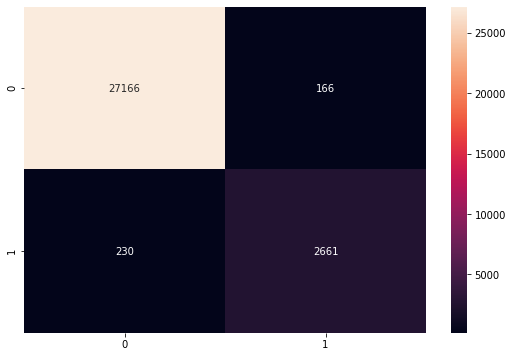

[[27166   166]
 [  230  2661]]
--*--
Classification par XGBoost
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27396
           1       0.92      0.94      0.93      2827

    accuracy                           0.99     30223
   macro avg       0.96      0.97      0.96     30223
weighted avg       0.99      0.99      0.99     30223



In [150]:
y_pred_xgb = classifier_xgb.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_xgb, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par XGBoost")
print(classification_report(y_true = y_test, y_pred  = classifier_xgb.predict(X_test)))

#### We can try to find the optimal parameters for our models.

In [462]:
## Decision Tree seems better to predict fraud let's try a grdi search for best params
tree_cv = DecisionTreeClassifier()
params = {'max_depth' : [5,10,15],
         'criterion' : ['gini', 'entropy' ],
          'splitter' : ['best', 'random'],
          'min_samples_split' : [i for i in range(1,111,10)],
          'min_samples_leaf' : [i for i in range(1,111,10)]}

grid_tree =  GridSearchCV(estimator=tree_cv, param_grid= params, cv = 5, n_jobs =-1)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [463]:
grid_tree.best_estimator_.predict

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 11,
 'min_samples_split': 101,
 'splitter': 'random'}

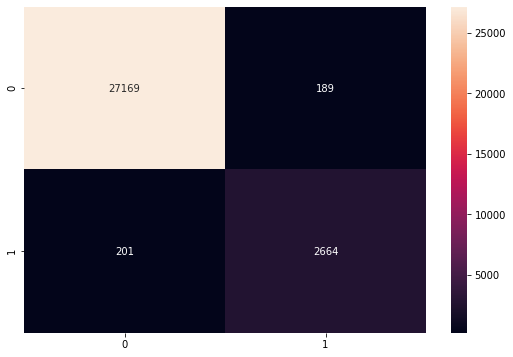

[[27169   189]
 [  201  2664]]
--*--
Classification par XGBoost
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27370
           1       0.93      0.93      0.93      2853

    accuracy                           0.99     30223
   macro avg       0.96      0.96      0.96     30223
weighted avg       0.99      0.99      0.99     30223



In [468]:
y_pred_tree_cv = grid_tree.best_estimator_.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_tree_cv, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par XGBoost")
print(classification_report(y_true = y_test, y_pred  = y_pred_tree_cv))

In [471]:
grid_tree.best_estimator_.score(X_train, y_train)

0.9889898998254597

In [472]:
grid_tree.best_estimator_.score(X_test, y_test)

0.9870959203255798

In [0]:
## We can do the qame with random Forest
rfc_cv = RandomForestClassifier()
params = {'n_estimators' : [50,100,200,500],
          'max_depth' : [5,10,15],
         'criterion' : ['gini', 'entropy' ],
          'min_samples_split' : [i for i in range(10,50,100)],
          'min_samples_leaf' : [i for i in range(10,50,100)]}


grid_rfc =  GridSearchCV(estimator=rfc_cv, param_grid= params, cv = 5, n_jobs =-1)
grid_rfc.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
grid_rfc.best_estimator_.score(X_traib, y_train)

In [0]:
y_pred_rfc_cv = grid_rfc.best_estimator_.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_rfc_cv, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par XGBoost")
print(classification_report(y_true = y_test, y_pred  = y_pred_rfc_cv))

## CONCLUSION

We manage to predict fraud with a percentage close to 90%  
By rebalancing the dataset we reach a score close to 100% however we have more false positives